ToDo: In this notebook.....

# Imports and Functions

In [1]:
from importlib import reload

import anndata
%matplotlib inline

import importlib.util
import sys
spec = importlib.util.spec_from_file_location("novosparc", "/home/vfs/PycharmProjects/rajewskyLab/novosparc/novosparc/__init__.py")
novosparc = importlib.util.module_from_spec(spec)
sys.modules["novosparc"] = novosparc
spec.loader.exec_module(novosparc)

# import novosparc
import os
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
plt.viridis()
from matplotlib.gridspec import GridSpec
# import altair as alt
from scipy.spatial.distance import cdist, squareform, pdist
from scipy.stats import ks_2samp
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import zscore
import sklearn
from sklearn.preprocessing import scale
from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
import random

<Figure size 432x288 with 0 Axes>

## Correlation measurement functions

In [2]:
def mse(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    return np.square(np.subtract(actual,pred)).mean()

def rmse(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    return np.sqrt(np.square(np.subtract(actual,pred)).mean())

def mean_pearson(actual, pred):
    r_per_gene = []
    for i in range(actual.shape[1]):
        r_score,p_value = pearsonr(actual[:,i],
                 pred[:,i])
        r_per_gene.append(r_score) # assumption all p-values are acceptable ToDo: make version with filtering for p-values
    return r_per_gene, np.mean(r_per_gene)

def mean_spearman(actual, pred):
    r_per_gene = []
    for i in range(actual.shape[1]):
        r_score,p_value = spearmanr(actual[:,i],
                 pred[:,i])
        r_per_gene.append(r_score) # assumption all p-values are acceptable ToDo: make version with filtering for p-values
    return r_per_gene, np.mean(r_per_gene)

def box_swarm_label(plot_df, score_name, single_dfs=None):
    ## plot_df must contain columns "gene", "r score (pearson)", and "method" (being the  reconstruction/cleaning)

    figure(figsize=(11, 12), dpi=80)

    sns.boxplot(x="method", y=score_name, data=plot_df, whis=np.inf)
    sns.swarmplot(x="method", y=score_name, data=plot_df,
                  palette=["crimson","indigo"])

    if single_dfs:
        for counter, single_df in enumerate(single_dfs):

            for x,y, label in zip([counter]*len(plot_df), single_df[score_name], single_df["gene"]):
                plt.text(x = x + 0.1, y = y,
                         s = label,
                         rotation= 45)
    plt.show()

def filter_matrix_for_genes(dataframe, gene_list):
    filtered_df = dataframe[dataframe.gene.isin(gene_list)]
    return filtered_df

def mean_ssim(actual, pred):
    ssim_per_gene = []
    for i in range(actual.shape[1]):
        ssim_score= ssim(actual[:,i],pred[:,i],
                         data_range= pred[:,i].max() -  pred[:,i].min())
        ssim_per_gene.append(ssim_score) # assumption all p-values are acceptable ToDo: make version with filtering for p-values
    return ssim_per_gene, np.mean(ssim_per_gene)
# def invest_plot_for_correlations(truth_df, list_of_expression_mtrx, list_of_special_genes, list_of_score_cutoffs)
# ToDo
plt.viridis()

<Figure size 432x288 with 0 Axes>

# Data - Read in data and atlas

In [42]:
# test genes
# I couldn't take some  frome the paper (bc they are not in the atlas but handpicked some with strong expression
# pattern

pl_genes_all = ['LGR5', # epithel
            'PAX2',# lumenal
            'SCGB2A2','PAEP', # glandular
            'IGF1', # stroma
            'CFD','CEBPB', 'PDGFRA', # secretory stroma
            'ACTA2', 'OGN' # fibroblasts
             ]
pl_genes = ['LGR5', # epithel
            'PAX2',# lumenal
            'IGF1' # stroma
            ]

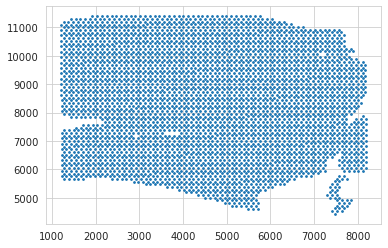

In [36]:

# atlas settings
atlas_dir = 'data/GarciaAlsono_uterus'
target_space_path = os.path.join(atlas_dir, 'endometr_coordinates.txt')
locations = pd.read_csv(target_space_path, sep='\t')

num_locations = 3871 # coming from the spatial data
locations_apriori = locations[:num_locations][['x', 'y']]
# the .values in this case messes up the dataformat. Only when I remove it I get what I need. Why?
locations = np.asarray(locations_apriori)
plt.scatter(locations_apriori[:, 0], locations_apriori[:, 1], s=3)

In [38]:
atlas_path = os.path.join(atlas_dir, 'uterus_GarciaAlsonso_atlas_dge.csv')
# atlas = sc.read_csv(atlas_path, delimiter=',') # this always through a Value Error about unmatching column numbers - idea why

chunks = pd.read_csv(atlas_path, index_col=0, chunksize=1000000)
df = pd.concat(chunks)
atlas = sc.AnnData(df)
atlas_genes = atlas.var.index.tolist()
atlas.obsm['spatial'] = locations

/tmp/ipykernel_55473/1608787609.py:6: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  atlas = sc.AnnData(df)
/home/vfs/anaconda3/envs/rajewskyLab/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


['RPAP3', 'PSMB2', 'RHOJ', 'SORT1', 'STC1', 'CRYL1', 'PDLIM3', 'AMIGO2', 'PDE10A', 'HIF3A', 'RTN2', 'GPER1', 'PTBP1', 'CHST10', 'ZBTB49', 'PDGFRB', 'ZNF362', 'ZNF821', 'PPP1R37', 'TAF15', 'GPRC5B', 'THTPA', 'TPSAB1', 'IGHMBP2', 'MGP', 'TRIM26', 'ZSCAN26', 'DAD1', 'BCAM', 'DLK1', 'RBM4B', 'PAPSS1', 'APOOL', 'AASDH', 'SGCD', 'CRLF3', 'SLC35C2', 'F8', 'IFFO1', 'ZBTB6', 'NRN1', 'RNASET2', 'HSF1', 'FMOD', 'ARHGEF4', 'HSPA4', 'JCAD', 'VPS26B', 'MYLK', 'HCFC1R1', 'SASS6', 'ZMAT3', 'ZFP30', 'AQP1', 'COL15A1', 'AC012085.2', 'PCGF5', 'C6orf136', 'PGM5', 'COL27A1', 'RAP2C', 'ZC3H6', 'MDM4', 'RNF126', 'PLPP7', 'SLC25A11', 'MRPS34', 'CYGB', 'CIDEB', 'PQLC2', 'MYRIP', 'COX4I2', 'SLC9B2', 'CSNK1G3', 'MBP', 'PCP4', 'NUAK1', 'F11R', 'PDP1', 'RERG', 'IL11RA', 'IRF3', 'GDAP1', 'RASD2', 'LINC01088', 'PLXNA2', 'DPP6', 'STAU2', 'EXOC2', 'EPRS', 'MCAM', 'DACT3', 'ARSI', 'SMG5', 'SF3B5', 'RMND5B', 'PHYHIP', 'PTP4A3', 'LRWD1', 'ECHDC3', 'DMXL1', 'WFDC1', 'MCFD2', 'IFI27L1', 'FHL3', 'MRPS30', 'NCAM1', 'SRL', 'F

<Figure size 432x288 with 0 Axes>

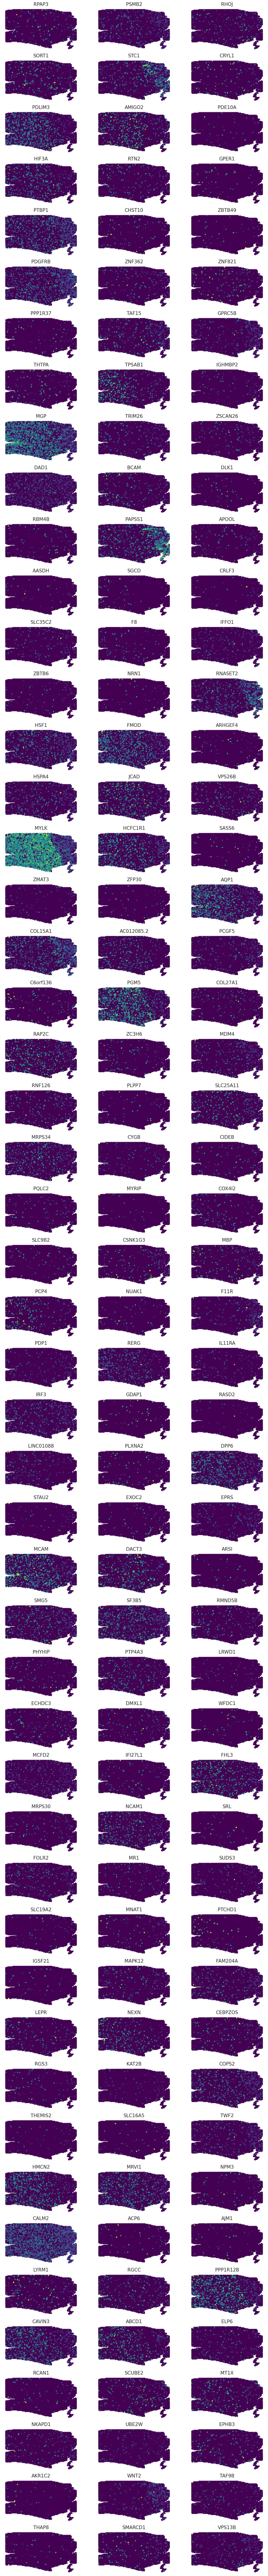

<Figure size 432x288 with 0 Axes>

In [48]:
print(atlas_genes)
plt.viridis()
novosparc.pl.embedding(atlas, atlas_genes)